In [3]:
# math and dataframes
import pandas as pd
import numpy as np

# machine learning
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV

# jupyter notebook full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# pandas formatting
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [4]:
# import data 
# all songs with audio features
df_10M = pd.read_pickle('df_10M.pickle')

### PIPELINE OUTLINE

* remove outliers
    * sets that aren't music
    * by inspection using songs less than 1min or more than 10min (+ more extreme)
* OPTIONAL: encode 
    * alt: drop when clustering
* transform data using min max scaler
* cluster based on AF (not genre)
    * optimise based on silhouette 
* examine clusters by inspecting genres and popularity

### OUTLIERS

In [5]:
%%time
# REMOVE OUTLIERS
# based on details in outlier analysis

# add cluster column to df_10M and add 'outliers' as a cluster
df_10M['cluster'] = pd.NA

# extrema to exclude (domain knowledge + inspection of percentiles)
dur_min = df_10M.duration_ms < 60_000
dur_max = df_10M.duration_ms > 600_000
val_0 = df_10M.valence == 0
sp_min = df_10M.speechiness > 0.947000
tempo_0 = df_10M.tempo == 0
loud_min = df_10M.loudness < -34.668999
dance_min = df_10M.danceability < 0.064400

df_10M.loc[(dur_min | dur_max | val_0 | sp_min | tempo_0 | loud_min | dance_min), 'cluster'] = 'outlier'

# genres that aren't music
genres_to_exclude = set([
    'sleep', 'football', 'halloween', 'birthday', 'lullaby', 'ringtone', 'fan chant',
    'sound effects', 'spoken word', 'bible', 'prank', 'wrestling', 'language', 'oratory',
    'erotica', 'tone', 'vintage radio show', 'sound', 'quran', 'islamic recitation',
    'reading', 'asmr', 'mindfulness', 'meditation', 'guided meditation', 'workout product',
    'theme', 'environmental', 'motivation'    
])

df_10M.loc[df_10M.genre.isin(genres_to_exclude), 'cluster'] = 'outlier'

# create a feature set to cluster on
X = df_10M[df_10M.cluster != 'outlier'].reset_index(drop=True)

Wall time: 4.15 s


In [6]:
# 6% of data dropped as outliers
X.shape[0], (1 - X.shape[0] / df_10M.shape[0])*100

(8827719, 6.404280009393792)

### DROP AND ENCODE COLUMNS

In [7]:
# encode and/or drop columns
drop_columns = ['song', 'artist', 'genre', 'release_date', 'cluster', 'in_B100']
encode_columns = ['key', 'mode', 'time_signature']
X = X.drop(drop_columns, axis=1).drop(encode_columns, axis=1).set_index('id')

### TRANSFORM DATA

In [8]:
## transform data to range from 0 to 1
attributes_to_transform = ['duration_ms', 'loudness', 'tempo']

for attribute in attributes_to_transform:
    X[attribute] = (X[attribute] - X[attribute].min()) / (X[attribute].max() - X[attribute].min())

In [ ]:
# X.to_pickle('X_precluster.pickle')

### CLUSTER DATA

In [14]:
# https://scikit-learn.org/stable/modules/clustering.html#mini-batch-kmeans

##### Silhouette Method

In [15]:
%%time
kmeans = KMeans(3).fit(X)

Wall time: 27.8 s


In [20]:
%%time
kmeans = KMeans(3).fit(X.head(1000))
score = silhouette_score(X.head(1000), kmeans.labels_)

Wall time: 81.8 ms


C:\Users\Kevin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [19]:
%%time
kmeans = KMeans(3).fit(X.head(10000))
score = silhouette_score(X.head(10000), kmeans.labels_)

Wall time: 1.54 s


In [18]:
%%time
kmeans = KMeans(3).fit(X.head(100000))
score = silhouette_score(X.head(100000), kmeans.labels_)

Wall time: 1min 46s


##### definitely can't do silhouette score as is, need sampling
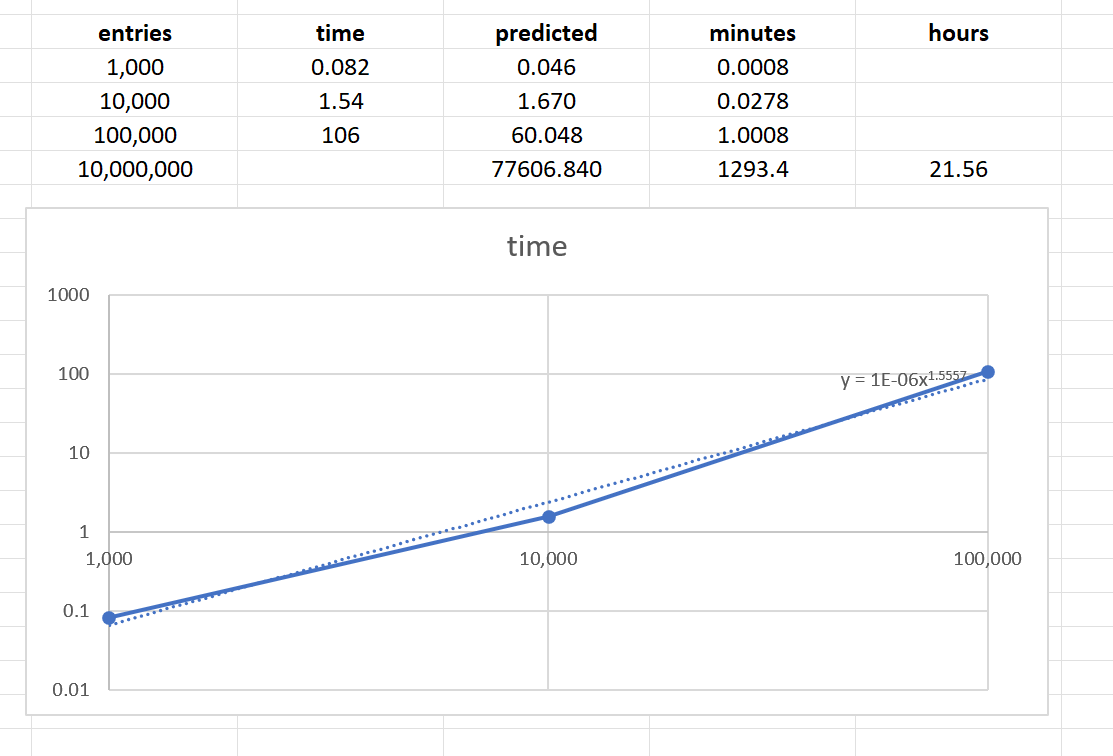

In [24]:
%%time
# can restrict it to approximately 1 minute per score using sample_size=100000
kmeans = KMeans(3).fit(X.head(100000))
score = silhouette_score(X.head(100000), kmeans.labels_, sample_size=50_000)

Wall time: 26.4 s


In [25]:
%%time
# can restrict it to approximately 1 minute per score using sample_size=100000
kmeans = KMeans(3).fit(X)
score = silhouette_score(X, kmeans.labels_, sample_size=50_000)

Wall time: 52.8 s


In [26]:
%%time
# time per n: 

# setup
n_clusters = [3, 4, 5, 6, 8, 10, 15, 20]
results = {}

# loop
for n in n_clusters:
    kmeans = KMeans(n).fit(X)
    score = silhouette_score(X, kmeans.labels_, sample_size=50_000)
    results[n] = score

# display results
results

Wall time: 13min 27s


{3: 0.2821724751018356,
 4: 0.2939383278460177,
 5: 0.23304552754496116,
 6: 0.2176436030028089,
 8: 0.2096411079563615,
 10: 0.20141793272826253,
 15: 0.16660631033595052,
 20: 0.14102224497793467}

In [27]:
%%time
# time per n: 

# setup
n_clusters = [3, 4, 5, 6, 8, 10, 15, 20]
sample_size = 200_000
results = {}

# loop
for n in n_clusters:
    kmeans = KMeans(n).fit(X)
    score = silhouette_score(X, kmeans.labels_, sample_size=sample_size)
    results[n] = score

# display results
results

Wall time: 1h 1min 21s


{3: 0.28418687162139655,
 4: 0.2937472857044909,
 5: 0.23345142491189227,
 6: 0.21839763822682923,
 8: 0.20987825401326532,
 10: 0.19002569873477773,
 15: 0.1640299274836951,
 20: 0.15314680377584255}

In [ ]:
# looks like very similar results
# k = 4 is optimal using the silhouette method

##### Elbow Method

In [ ]:
## examine performance by inspecting genres and popularity

